# GLM Interactive Model Comparison

Compare different variable groupings using:
- Likelihood Ratio Tests
- AIC/BIC metrics
- Visual comparison of coefficients

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import glm
from scipy import stats
import re
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style('whitegrid')
%matplotlib inline

## Load Data

In [13]:
df = pd.read_csv('GLM_KTH_Data_Train.csv')

## Define Grouping Strategies

In [14]:
COLUMN_MAPPING = {
    'NoPGroup': 'NumberOfPersons',
    'ActivityGroup': 'ActivityCode',
    'FinancialRatingGroup': 'FinancialRating',
    'TravellingAreaGroup': 'TravellingArea'
}

def create_grouping_strategies():
    strategies = {}
    
    strategies['NoPGroup'] = {
        'v1_simple': lambda x: pd.cut(x, bins=[0, 4, 100, np.inf], 
                                       labels=['01.<4', '02.4-100', '03.>100']),
        'v2_medium': lambda x: pd.cut(x, bins=[0, 2, 4, 14, 49, 99, np.inf], 
                                       labels=['01.<2', '02.2-4', '03.5-14', 
                                               '04.15-49', '05.50-99', '06.>=100']),
        'v3_detailed': lambda x: pd.cut(x, bins=[0, 1, 2, 4, 10, 20, 50, 100, np.inf], 
                                         labels=['01.1', '02.2', '03.3-4', '04.5-10', 
                                                 '05.11-20', '06.21-50', '07.51-100', '08.>100'])
    }
    
    strategies['ActivityGroup'] = {
        'v1_simple': lambda x: x.apply(lambda c: 
                                        'Industry' if c in ['C', 'F'] else
                                        'Service' if c in ['G', 'K', 'M', 'L', 'Q'] else
                                        'Other'),
        'v2_medium': lambda x: x.apply(lambda c: 
                                        'Manufacturing' if c in ['C'] else
                                        'Construction' if c in ['F'] else
                                        'Finance/Tech' if c in ['K', 'M'] else
                                        'Services' if c in ['G', 'L', 'Q'] else
                                        'Other'),
        'v3_keep_all': lambda x: x
    }
    
    strategies['FinancialRatingGroup'] = {
        'v1_simple': lambda x: x.apply(lambda r: 
                                        'High' if r in ['AAA', 'AA'] else
                                        'Medium' if r in ['A', 'B'] else
                                        'Low' if r in ['IR', 'NR'] else
                                        'Missing'),
        'v2_medium': lambda x: x.apply(lambda r: 
                                        'AAA' if r == 'AAA' else
                                        'AA' if r == 'AA' else
                                        'A-B' if r in ['A', 'B'] else
                                        'Low' if r in ['IR', 'NR'] else
                                        'Missing'),
        'v3_detailed': lambda x: x
    }
    
    strategies['TravellingAreaGroup'] = {
        'v1_simple': lambda x: x.apply(lambda a: 
                                        'Sweden' if a == 'Sweden' else 'Other'),
        'v2_medium': lambda x: x.apply(lambda a: 
                                        'Sweden' if a == 'Sweden' else
                                        'Nordic' if 'Scandinavia' in str(a) or 'Nordic' in str(a) else
                                        'Europe' if 'Europe' in str(a) else
                                        'World'),
        'v3_keep_all': lambda x: x
    }
    
    return strategies

grouping_strategies = create_grouping_strategies()

## Model Functions

In [15]:
def get_model_coefficients(model, col_name):
    matching_params = model.params[model.params.index.str.contains(col_name)]
    
    if len(matching_params) == 0:
        return pd.Series([1.0], index=['All']), pd.Series([1.0], index=['All']), pd.Series([1.0], index=['All'])
    
    coefs = np.exp(matching_params)
    
    try:
        ref = coefs.index[-1]
        ref = re.sub(r".*?[\=]", "", ref, 1)
        ref = re.sub(r"[\)].*", "", ref)[1:-1]
    except:
        ref = "Reference"
    
    coefs.index = (coefs.index.str.replace(".*[\)]", "", regex=True)
                   .str.replace("T.", "").str.replace("[", "").str.replace("]", ""))
    coefs = pd.concat([coefs, pd.Series([1], index=[ref])]).sort_index()
    
    conf_int = np.exp(model.conf_int()[model.params.index.str.contains(col_name)])
    conf_int.index = (conf_int.index.str.replace(".*[\)]", "", regex=True)
                      .str.replace("T.", "").str.replace("[", "").str.replace("]", ""))
    
    lower = pd.concat([conf_int[0], pd.Series([1], index=[ref])]).sort_index()
    upper = pd.concat([conf_int[1], pd.Series([1], index=[ref])]).sort_index()
    
    return coefs, lower, upper


def test_grouping_scenario(df, scenario_config, model_type='frequency'):
    df_copy = df.copy()
    
    for var, strategy_name in scenario_config.items():
        strategy_func = grouping_strategies[var][strategy_name]
        source_col = COLUMN_MAPPING[var]
        df_copy[var] = strategy_func(df[source_col])
    
    variables = list(scenario_config.keys())
    df_agg = (df_copy[variables + ['Duration', 'NumberOfClaims', 'ClaimCost']]
              .groupby(variables, observed=True)
              .agg('sum')
              .reset_index())
    
    df_agg['AvgClaimCost'] = df_agg['ClaimCost'] / df_agg['NumberOfClaims']
    
    refs = {}
    for var in variables:
        refs[var] = df_copy.groupby(var, observed=True)['Duration'].sum().idxmax()
    
    formula_parts = [f'C({var}, Treatment(reference="{refs[var]}"))' for var in variables]
    
    df_agg_filtered = df_agg[df_agg['Duration'] > 0.001].copy()
    
    if model_type == 'frequency':
        formula = 'NumberOfClaims ~ ' + ' + '.join(formula_parts)
        model = glm(formula=formula, data=df_agg_filtered,
                   family=sm.families.Poisson(),
                   exposure=df_agg_filtered['Duration']).fit()
    else:
        df_agg_filtered = df_agg_filtered[df_agg_filtered['NumberOfClaims'] > 0]
        formula = 'AvgClaimCost ~ ' + ' + '.join(formula_parts)
        model = glm(formula=formula, data=df_agg_filtered,
                   family=sm.families.Gamma(link=sm.families.links.Log()),
                   var_weights=df_agg_filtered['NumberOfClaims']).fit()
    
    return model, df_agg, formula


def likelihood_ratio_test(model_simple, model_complex):
    lr_stat = 2 * (model_complex.llf - model_simple.llf)
    df_diff = model_complex.df_model - model_simple.df_model
    p_value = stats.chi2.sf(lr_stat, df_diff)
    return lr_stat, p_value, df_diff

## Visualization Functions

In [16]:
def plot_model_comparison(models_dict, model_type='frequency'):
    
    # Metrics comparison
    metrics = pd.DataFrame([
        {'Model': name, 'AIC': m.aic, 'BIC': m.bic, 'Log-Likelihood': m.llf, 'Deviance': m.deviance}
        for name, m in models_dict.items()
    ])
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # AIC comparison
    axes[0].bar(range(len(metrics)), metrics['AIC'])
    axes[0].set_xticks(range(len(metrics)))
    axes[0].set_xticklabels(metrics['Model'], rotation=45, ha='right')
    axes[0].set_ylabel('AIC')
    axes[0].set_title('AIC Comparison (lower is better)')
    axes[0].axhline(metrics['AIC'].min(), color='red', linestyle='--', alpha=0.5)
    
    # BIC comparison
    axes[1].bar(range(len(metrics)), metrics['BIC'])
    axes[1].set_xticks(range(len(metrics)))
    axes[1].set_xticklabels(metrics['Model'], rotation=45, ha='right')
    axes[1].set_ylabel('BIC')
    axes[1].set_title('BIC Comparison (lower is better)')
    axes[1].axhline(metrics['BIC'].min(), color='red', linestyle='--', alpha=0.5)
    
    # Deviance comparison
    axes[2].bar(range(len(metrics)), metrics['Deviance'])
    axes[2].set_xticks(range(len(metrics)))
    axes[2].set_xticklabels(metrics['Model'], rotation=45, ha='right')
    axes[2].set_ylabel('Deviance')
    axes[2].set_title('Deviance Comparison (lower is better)')
    axes[2].axhline(metrics['Deviance'].min(), color='red', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    return metrics


def plot_lr_tests(lr_tests):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    comparisons = [f"{t['model1']} vs\n{t['model2']}" for t in lr_tests]
    
    # LR statistics
    axes[0].bar(range(len(lr_tests)), [t['lr_stat'] for t in lr_tests])
    axes[0].set_xticks(range(len(lr_tests)))
    axes[0].set_xticklabels(comparisons, rotation=0)
    axes[0].set_ylabel('LR Statistic')
    axes[0].set_title('Likelihood Ratio Statistics')
    
    # P-values
    colors = ['green' if t['p_value'] < 0.05 else 'red' for t in lr_tests]
    axes[1].bar(range(len(lr_tests)), [t['p_value'] for t in lr_tests], color=colors)
    axes[1].axhline(0.05, color='black', linestyle='--', label='alpha=0.05')
    axes[1].set_xticks(range(len(lr_tests)))
    axes[1].set_xticklabels(comparisons, rotation=0)
    axes[1].set_ylabel('P-value')
    axes[1].set_title('P-values (green=significant)')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()


def plot_coefficients_comparison(models_dict, variable):
    n_models = len(models_dict)
    fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5))
    if n_models == 1:
        axes = [axes]
    
    for idx, (name, model) in enumerate(models_dict.items()):
        coefs, lower, upper = get_model_coefficients(model, variable)
        
        if len(coefs) == 1:
            axes[idx].text(0.5, 0.5, 'Variable not in model', 
                          ha='center', va='center', transform=axes[idx].transAxes)
            axes[idx].set_title(name)
            continue
        
        x = range(len(coefs))
        axes[idx].plot(x, coefs.values, 'o-', linewidth=2, markersize=8, label='Coefficient')
        axes[idx].fill_between(x, lower.values, upper.values, alpha=0.3, label='95% CI')
        axes[idx].axhline(y=1, color='black', linestyle='--', alpha=0.5)
        axes[idx].set_xticks(x)
        axes[idx].set_xticklabels(coefs.index, rotation=45, ha='right')
        axes[idx].set_ylabel('Relative Risk')
        axes[idx].set_title(f'{name}\nAIC: {model.aic:.1f}')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)
    
    fig.suptitle(f'{variable} Coefficients Comparison', y=1.02, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


def plot_data_diagnostic(df_agg, variables):
    df_sev = df_agg[df_agg['NumberOfClaims'] > 0]
    
    n_vars = len(variables)
    fig, axes = plt.subplots(2, n_vars, figsize=(5*n_vars, 8))
    if n_vars == 1:
        axes = axes.reshape(-1, 1)
    
    for idx, var in enumerate(variables):
        # Number of claims per group
        claims_by_group = df_sev.groupby(var)['NumberOfClaims'].sum().sort_index()
        axes[0, idx].bar(range(len(claims_by_group)), claims_by_group.values)
        axes[0, idx].set_xticks(range(len(claims_by_group)))
        axes[0, idx].set_xticklabels(claims_by_group.index, rotation=45, ha='right')
        axes[0, idx].set_ylabel('Number of Claims')
        axes[0, idx].set_title(f'{var} - Claims Distribution')
        axes[0, idx].axhline(20, color='red', linestyle='--', alpha=0.5, label='Min threshold (20)')
        axes[0, idx].legend()
        
        # Duration per group
        duration_by_group = df_sev.groupby(var)['Duration'].sum().sort_index()
        axes[1, idx].bar(range(len(duration_by_group)), duration_by_group.values)
        axes[1, idx].set_xticks(range(len(duration_by_group)))
        axes[1, idx].set_xticklabels(duration_by_group.index, rotation=45, ha='right')
        axes[1, idx].set_ylabel('Total Duration')
        axes[1, idx].set_title(f'{var} - Duration Distribution')
    
    plt.tight_layout()
    plt.show()

## Test Different Groupings

In [17]:
# Define base configuration
base_config = {
    'ActivityGroup': 'v1_simple',
    'FinancialRatingGroup': 'v1_simple',
    'TravellingAreaGroup': 'v2_medium'
}

# Test different NoPGroup strategies
models_to_compare = {}

config1 = {**base_config, 'NoPGroup': 'v1_simple'}
model1, agg1, _ = test_grouping_scenario(df, config1, model_type='frequency')
models_to_compare['v1_simple'] = model1

config2 = {**base_config, 'NoPGroup': 'v2_medium'}
model2, agg2, _ = test_grouping_scenario(df, config2, model_type='frequency')
models_to_compare['v2_medium'] = model2

config3 = {**base_config, 'NoPGroup': 'v3_detailed'}
model3, agg3, _ = test_grouping_scenario(df, config3, model_type='frequency')
models_to_compare['v3_detailed'] = model3

## Model Comparison Plots

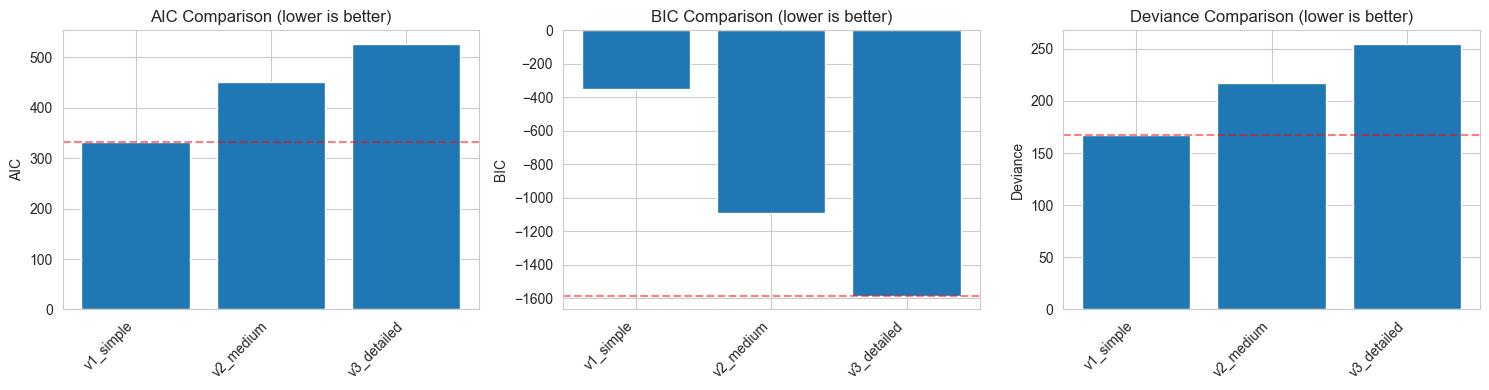

,Model,AIC,BIC,Log-Likelihood,Deviance
0,v1_simple,332.532418,-349.168303,-155.266209,166.977034
1,v2_medium,451.933214,-1091.839063,-211.966607,217.693284
2,v3_detailed,527.337027,-1586.259413,-247.668513,254.921756


In [18]:
metrics = plot_model_comparison(models_to_compare, model_type='frequency')
display(metrics)

## Likelihood Ratio Tests

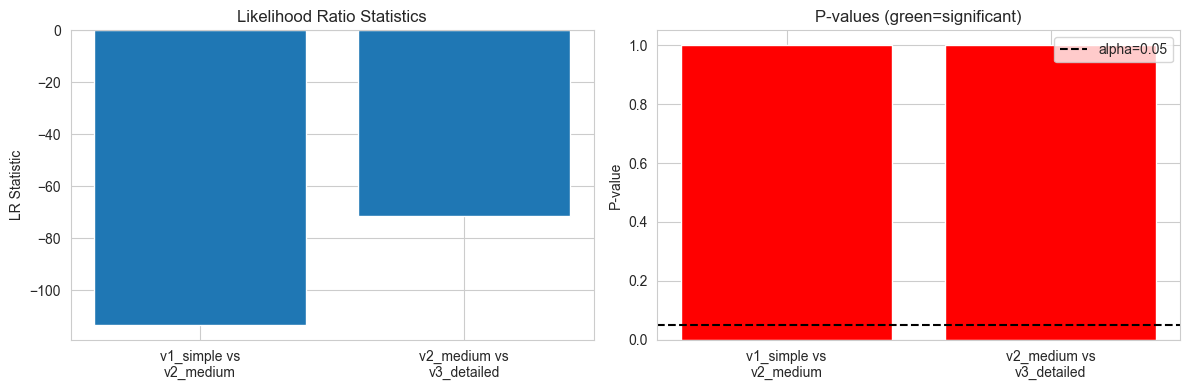

,model1,model2,lr_stat,p_value,df
0,v1_simple,v2_medium,-113.400796,1.0,3
1,v2_medium,v3_detailed,-71.403813,1.0,2


In [19]:
lr_tests = []

lr_stat_12, p_val_12, df_12 = likelihood_ratio_test(model1, model2)
lr_tests.append({
    'model1': 'v1_simple',
    'model2': 'v2_medium',
    'lr_stat': lr_stat_12,
    'p_value': p_val_12,
    'df': df_12
})

lr_stat_23, p_val_23, df_23 = likelihood_ratio_test(model2, model3)
lr_tests.append({
    'model1': 'v2_medium',
    'model2': 'v3_detailed',
    'lr_stat': lr_stat_23,
    'p_value': p_val_23,
    'df': df_23
})

plot_lr_tests(lr_tests)
display(pd.DataFrame(lr_tests))

## Coefficients Comparison

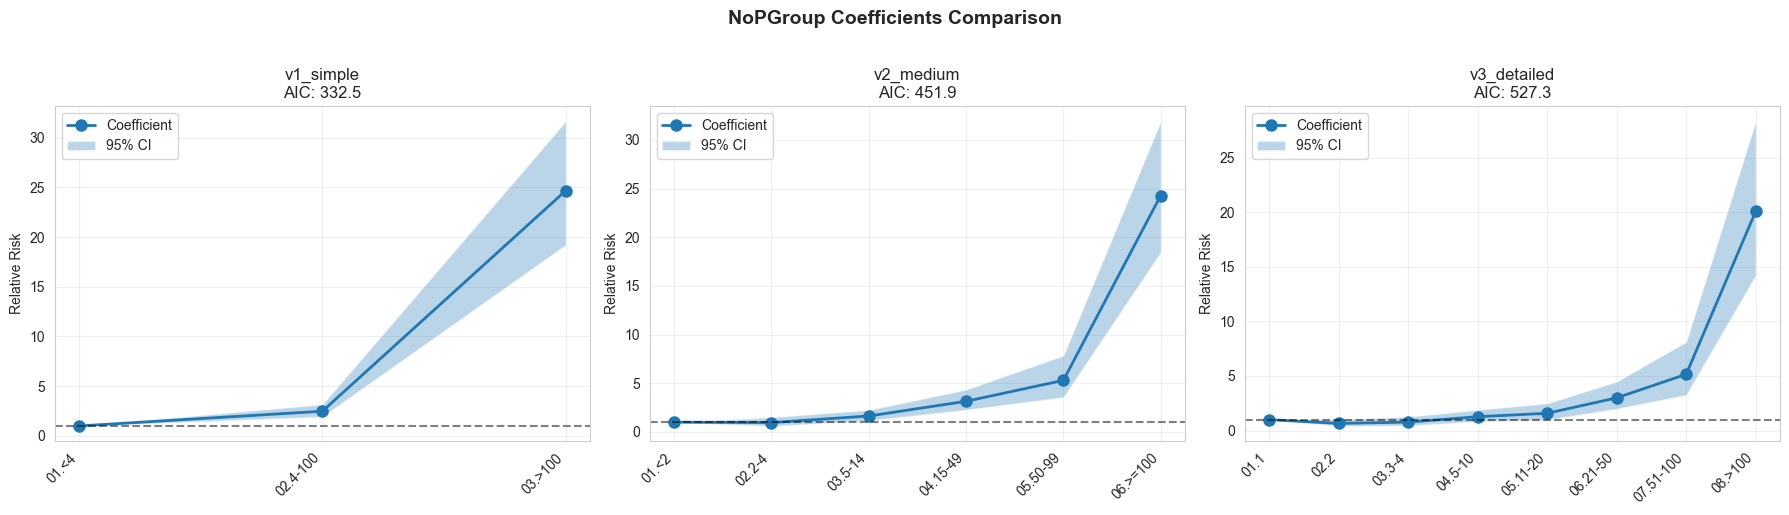

In [20]:
plot_coefficients_comparison(models_to_compare, 'NoPGroup')

## Data Availability Diagnostic

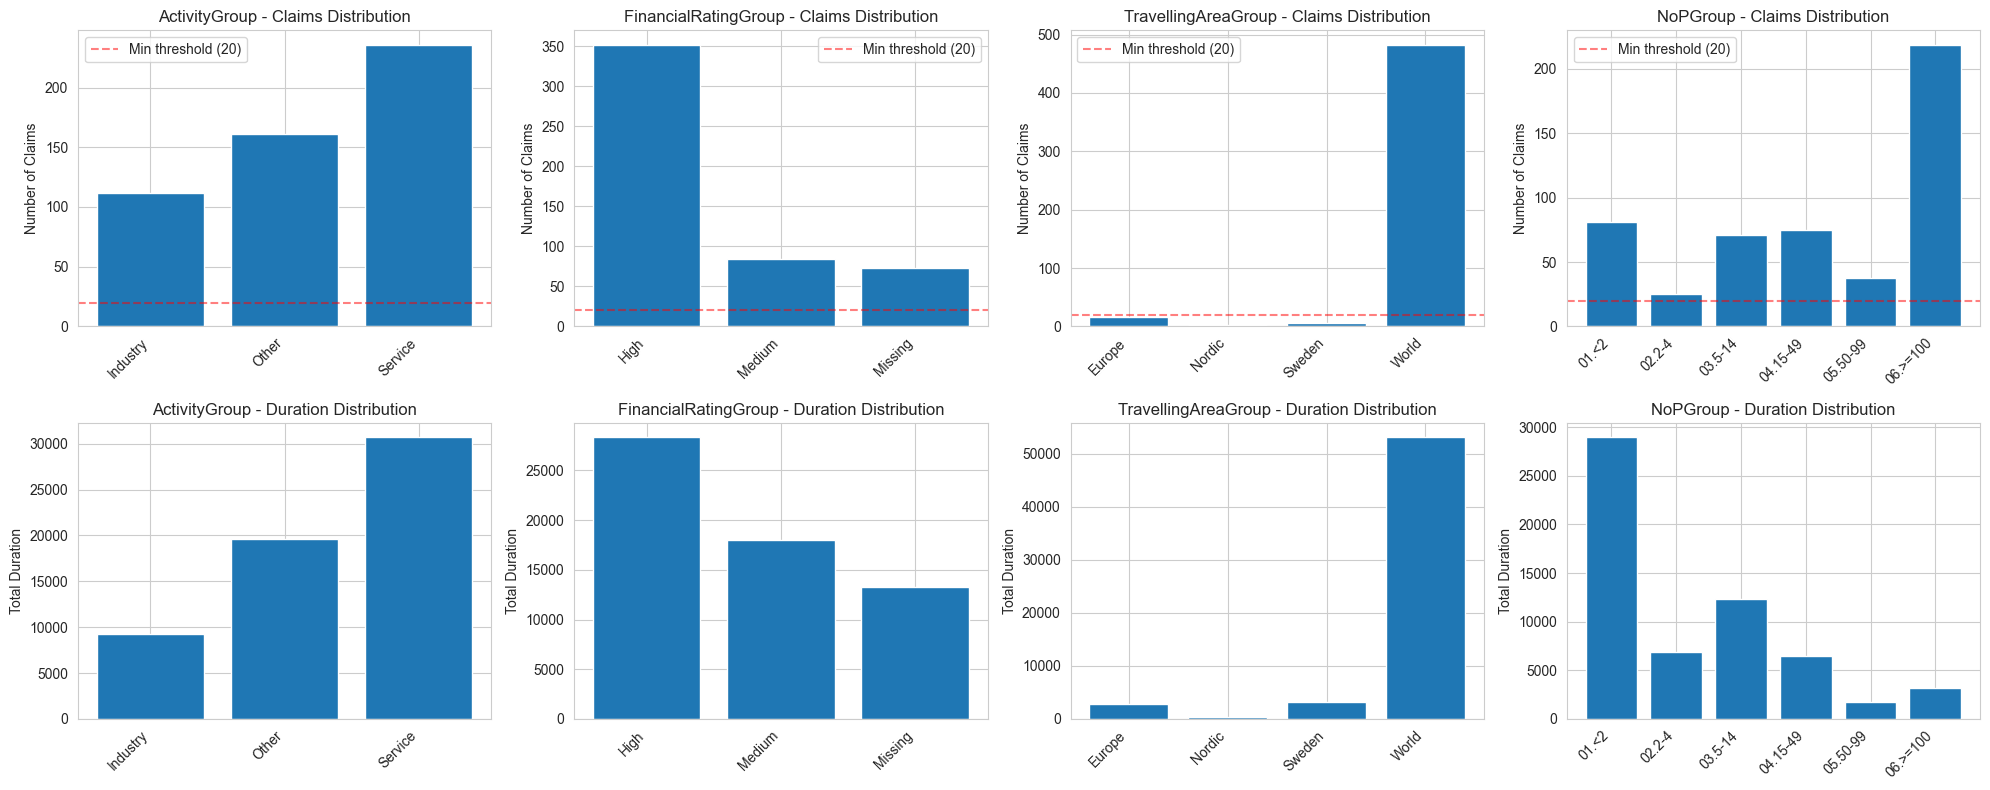

In [21]:
plot_data_diagnostic(agg2, list(config2.keys()))

## Interactive Testing

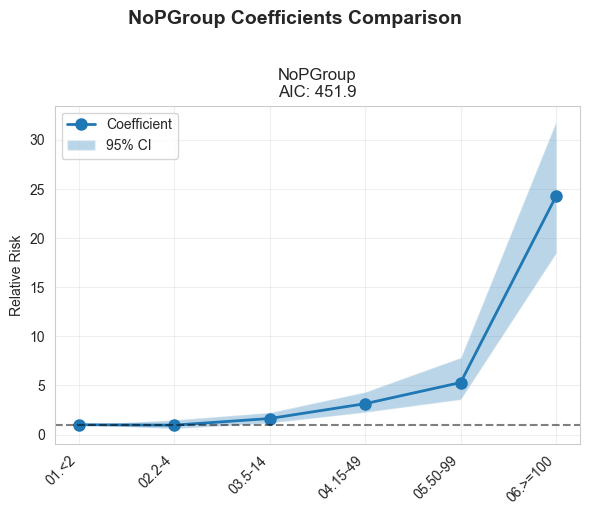

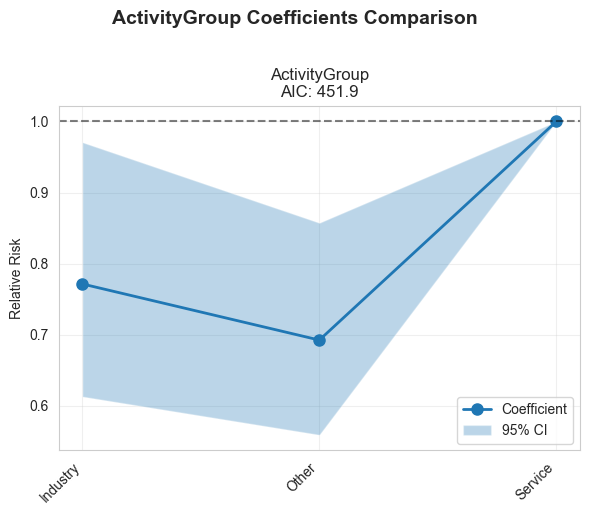

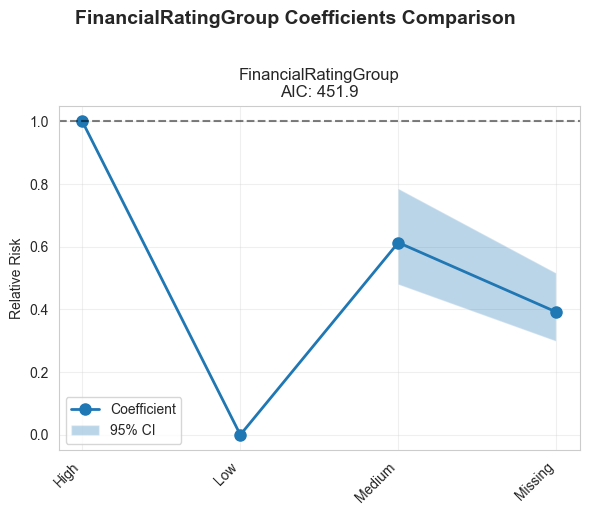

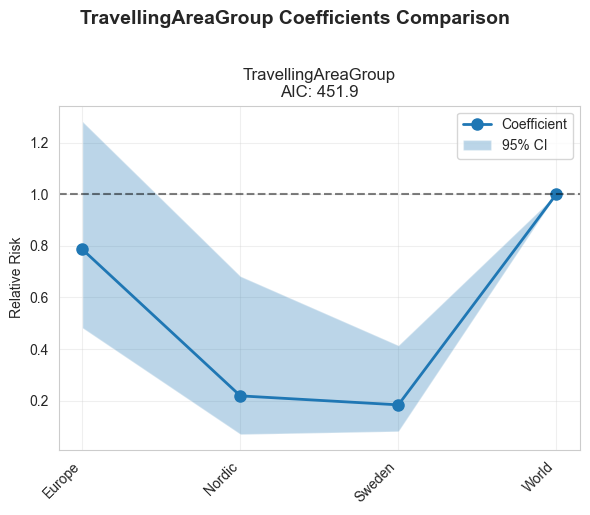

In [22]:
my_config = {
    'NoPGroup': 'v2_medium',
    'ActivityGroup': 'v1_simple',
    'FinancialRatingGroup': 'v1_simple',
    'TravellingAreaGroup': 'v2_medium'
}

my_model, my_agg, _ = test_grouping_scenario(df, my_config, model_type='frequency')

# Plot individual variable effects
for var in my_config.keys():
    plot_coefficients_comparison({f'{var}': my_model}, var)